In [86]:
import pandas as pd
import numpy as np
import pandas_profiling as pdp
import lightgbm as lgb
import random
from numba import jit
import os,sys
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.dates import DateFormatter
%matplotlib inline
import seaborn as sns
import gc

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if "tr" in sys.modules:
        tf.random.set_seed(seed)

seed_everything(28)

#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/atoma08_game/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/atoma08_game/data/test.csv')
train

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0,4,0,0,4,78.0,57.0,8,569.0,Paradox Development Studio,NaN
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
!pip install texthero

# NGRAMS生成

In [89]:
import texthero as hero
from texthero import preprocessing
from nltk.util import ngrams
def line_ngram(line, n=2):
    words = [w for w in line.split(' ') if len(w) != 0] # 空文字は取り除く
    return list(ngrams(words, n))

custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords # stopword
]


Index([         ('star', 'wars'),         ('madden', 'nfl'),
            ('final', 'fantasy'),           ('jp', 'sales'),
               ('pro', 'yakyuu'),         ('tom', 'clancy'),
               ('need', 'speed'),        ('dragon', 'ball'),
              ('fifa', 'soccer'),   ('jikkyou', 'powerful'),
             ('harry', 'potter'),       ('powerful', 'pro'),
               ('spider', 'man'),          ('call', 'duty'),
            ('pro', 'evolution'),   ('evolution', 'soccer'),
            ('resident', 'evil'),           ('mega', 'man'),
                 ('pga', 'tour'),        ('super', 'robot'),
         ('dynasty', 'warriors'),        ('tiger', 'woods'),
                ('woods', 'pga'),          ('tony', 'hawk'),
             ('major', 'league'),           ('nba', 'live'),
               ('video', 'game'),          ('rock', 'band'),
                   ('ball', 'z'), ('world', 'championship')],
      dtype='object')


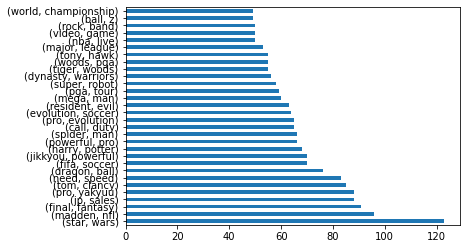

In [90]:
df_whole = pd.concat([train, test], axis=0)

# clean:小文字化, 数字削除?, 句読点削除, 発音区別符号削除, ストップワード削除, 
names = hero.clean(df_whole['Name'], custom_pipeline)

# リスト化
words = [w for row in names.str.split(' ') for w in row if len(w) > 0]

# n=2単語単位
name_grams = names.map(line_ngram)
#name_grams

grams = [x for row in name_grams for x in row if len(x) > 0]
#grams

# 可視化
pd.Series(grams).value_counts().head(30).plot(kind='barh')
top_grams = pd.Series(grams).value_counts().head(30).index
print(top_grams)

In [91]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()

def clearn_by_hero(x):
    custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]
    return hero.clean(x, custom_pipeline)

def create_n_gram(x, n=3):
    x = clearn_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NameNGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n

    def fit(self, input_df, y=None, num=20):
        name_grams = create_n_gram(self.whole_df['Name'], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(num).index

        self.top_grams_ = top_grams
        return self.transform(input_df)

    def transform(self, input_df):
        name_grams = create_n_gram(input_df['Name'], n=self.n)
        output_df = pd.DataFrame()

        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')


# 2.特徴量生成

In [92]:
df_whole=pd.concat([train, test], axis=0)
# 単語数nで初期化
block = NameNGramBlock(df_whole, n=3)
# fit
_df1 = block.fit(df_whole, num=60)

# OneHot
train_ = pd.concat([train, _df1.iloc[:len(train),:]], axis=1)
test_  = pd.concat([train, _df1.iloc[len(train):,:]], axis=1)

# ngramの最大 Count数
_df = (_df1 * _df1.sum(axis=0)).max(axis=1)
#train[f'ngram_count'] = _df.iloc[:len(train)]
#test[f'ngram_count'] = _df.iloc[len(train):]

train_.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Name_has_jikkyou-powerful-pro_n=3,Name_has_pro-evolution-soccer_n=3,Name_has_powerful-pro-yakyuu_n=3,Name_has_tiger-woods-pga_n=3,Name_has_woods-pga-tour_n=3,Name_has_dragon-ball-z_n=3,Name_has_yu-gi-oh_n=3,Name_has_major-league-baseball_n=3,Name_has_super-robot-taisen_n=3,...,Name_has_mx-vs-atv_n=3,Name_has_advance-video-volume_n=3,Name_has_fifa-world-cup_n=3,Name_has_star-wars-force_n=3,Name_has_marvel-super-heroes_n=3,Name_has_world-soccer-winning_n=3,Name_has_soccer-winning-eleven_n=3,Name_has_romance-three-kingdoms_n=3,Name_has_call-duty-modern_n=3,Name_has_duty-modern-warfare_n=3,Name_has_hisshou-pachinko-pachi_n=3,Name_has_pachi-slot-kouryaku_n=3,Name_has_slot-kouryaku-series_n=3,Name_has_kung-fu-panda_n=3,Name_has_pachinko-pachi-slot_n=3,Name_has_shippuden-ultimate-ninja_n=3,Name_has_power-pro-kun_n=3,Name_has_naruto-shippuden-ultimate_n=3,Name_has_duty-black-ops_n=3,Name_has_lego-harry-potter_n=3,Name_has_call-duty-black_n=3,Name_has_pac-man-world_n=3,Name_has_super-monkey-ball_n=3,Name_has_harry-potter-years_n=3,Name_has_band-track-pack_n=3
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [93]:
_df1.head(5)

,Name_has_jikkyou-powerful-pro_n=3,Name_has_pro-evolution-soccer_n=3,Name_has_powerful-pro-yakyuu_n=3,Name_has_tiger-woods-pga_n=3,Name_has_woods-pga-tour_n=3,Name_has_dragon-ball-z_n=3,Name_has_yu-gi-oh_n=3,Name_has_major-league-baseball_n=3,Name_has_super-robot-taisen_n=3,Name_has_metal-gear-solid_n=3,Name_has_mobile-suit-gundam_n=3,Name_has_teenage-mutant-ninja_n=3,Name_has_lego-star-wars_n=3,Name_has_mutant-ninja-turtles_n=3,Name_has_smackdown-vs-raw_n=3,Name_has_wwe-smackdown-vs_n=3,Name_has_grand-theft-auto_n=3,Name_has_shin-megami-tensei_n=3,Name_has_dance-dance-revolution_n=3,Name_has_tom-clancy-splinter_n=3,Name_has_clancy-splinter-cell_n=3,Name_has_game-boy-advance_n=3,Name_has_boy-advance-video_n=3,Name_has_pro-yaky-spirits_n=3,Name_has_tom-clancy-ghost_n=3,...,Name_has_mx-vs-atv_n=3,Name_has_advance-video-volume_n=3,Name_has_fifa-world-cup_n=3,Name_has_star-wars-force_n=3,Name_has_marvel-super-heroes_n=3,Name_has_world-soccer-winning_n=3,Name_has_soccer-winning-eleven_n=3,Name_has_romance-three-kingdoms_n=3,Name_has_call-duty-modern_n=3,Name_has_duty-modern-warfare_n=3,Name_has_hisshou-pachinko-pachi_n=3,Name_has_pachi-slot-kouryaku_n=3,Name_has_slot-kouryaku-series_n=3,Name_has_kung-fu-panda_n=3,Name_has_pachinko-pachi-slot_n=3,Name_has_shippuden-ultimate-ninja_n=3,Name_has_power-pro-kun_n=3,Name_has_naruto-shippuden-ultimate_n=3,Name_has_duty-black-ops_n=3,Name_has_lego-harry-potter_n=3,Name_has_call-duty-black_n=3,Name_has_pac-man-world_n=3,Name_has_super-monkey-ball_n=3,Name_has_harry-potter-years_n=3,Name_has_band-track-pack_n=3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [94]:
print('### ngram count:\n',_df1.sum()[:30])

### ngram count:
 Name_has_jikkyou-powerful-pro_n=3      66
Name_has_pro-evolution-soccer_n=3      64
Name_has_powerful-pro-yakyuu_n=3       62
Name_has_tiger-woods-pga_n=3           55
Name_has_woods-pga-tour_n=3            55
Name_has_dragon-ball-z_n=3             49
Name_has_yu-gi-oh_n=3                  48
Name_has_major-league-baseball_n=3     47
Name_has_super-robot-taisen_n=3        45
Name_has_metal-gear-solid_n=3          36
Name_has_mobile-suit-gundam_n=3        33
Name_has_teenage-mutant-ninja_n=3      31
Name_has_lego-star-wars_n=3            31
Name_has_mutant-ninja-turtles_n=3      31
Name_has_smackdown-vs-raw_n=3          30
Name_has_wwe-smackdown-vs_n=3          30
Name_has_grand-theft-auto_n=3          28
Name_has_shin-megami-tensei_n=3        28
Name_has_dance-dance-revolution_n=3    27
Name_has_tom-clancy-splinter_n=3       26
Name_has_clancy-splinter-cell_n=3      26
Name_has_game-boy-advance_n=3          25
Name_has_boy-advance-video_n=3         25
Name_has_pro-yak

In [95]:
print('### total count num;\n',_df)

### total count num;
 0        0
1        0
2        0
3        0
4       15
        ..
8355    20
8356    20
8357     0
8358     0
8359     0
Length: 16719, dtype: int64


# 3.関数化 & テスト

In [96]:
train

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0,4,0,0,4,78.0,57.0,8,569.0,Paradox Development Studio,NaN
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
def fe_ngrams_oh(train, test, n=2, num=20, display_values=False):
    """
    機能：単語の組み合わせをOneHot特徴量化
    n:n単語でカウント
    num:カウント数上位num個で特徴量生成(num個未満は使わない)
    """
    df_whole=pd.concat([train, test], axis=0)
    # 単語数nで初期化
    block = NameNGramBlock(df_whole, n=n)
    # fit
    df1 = block.fit(df_whole, num=num)

    # OneHot
    train = pd.concat([train, df1.iloc[:len(train),:]],axis=1)
    test  = pd.concat([test, df1.iloc[len(train):,:]],axis=1)

    #if display_values:
    #    print('ngram count:\n',_df1.sum())

    return train, test

def fe_ngrams_cnt(train, test, n=2, num=20, display_values=False):
    """
    機能：単語の組み合わせの出現数で特徴量化
    n:n単語でカウント
    num:カウント数上位num個で特徴量生成(num個未満は使わない)
    """
    df_whole=pd.concat([train, test], axis=0)
    # 単語数nで初期化
    block = NameNGramBlock(df_whole, n=n)
    # fit
    df1 = block.fit(df_whole, num=num)

    # ngramの最大 Count数
    _df = (_df1 * _df1.sum(axis=0)).max(axis=1)
    train[f'ngram{n}_cnt'] = _df[:len(train)]
    test[f'ngram{n}_cnt'] = _df[len(train):]

    #if display_values:
    #    print('ngram count:\n',_df1.sum())
    #    print('total count num;\n',_df)
    return train, test

In [98]:
# OneHot
train_, test_ = fe_ngrams_oh(train, test, True)
train_

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Name_has_world_n=True,Name_has_pro_n=True,Name_has_game_n=True,Name_has_ii_n=True,Name_has_super_n=True,Name_has_star_n=True,Name_has_soccer_n=True,Name_has_dragon_n=True,Name_has_ds_n=True,Name_has_wars_n=True,Name_has_man_n=True,Name_has_battle_n=True,Name_has_nba_n=True,Name_has_nfl_n=True,Name_has_disney_n=True,Name_has_vs_n=True,Name_has_lego_n=True,Name_has_heroes_n=True,Name_has_collection_n=True,Name_has_party_n=True
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0,4,0,0,4,78.0,57.0,8,569.0,Paradox Development Studio,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [99]:
# ngrams count
train_, test_ = fe_ngrams_cnt(train, test, True)
train_

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,ngramTrue_cnt
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,0
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,0
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN,0
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0,4,0,0,4,78.0,57.0,8,569.0,Paradox Development Studio,NaN,0
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,0
